In [1]:
import numpy as np
import scipy as sp
import uproot
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
import vector
from scipy.optimize import curve_fit

In [2]:
file = uproot.open('uproot-tutorial-file.root') #opening a ROOT file

file

<ReadOnlyDirectory '/' at 0x7f25cf20c580>

In [3]:
file.keys() #;1 is the cycle number. A key refers to the name of each item in the file.

['Events;1']

In [4]:
file.classnames() #Classname refers to the type of each item.

{'Events': 'TTree'}

In [5]:
file['Events'] #Accessing the TTree object

<TTree 'Events' (6 branches) at 0x7f25bff905b0>

In [6]:
tree = file['Events'] #Trees are tables of information. Trees are composed of branches (columns of the table)

tree.keys()

['nMuon', 'Muon_pt', 'Muon_eta', 'Muon_phi', 'Muon_mass', 'Muon_charge']

In [7]:
#Simplest way to get data from table is using arrays

tree.arrays()

<Array [{nMuon: 2, Muon_pt: [10.8, ... -1, 1]}] type='100000 * {"nMuon": uint32,...'>

In [8]:
branches = tree.arrays()

branches['nMuon'] 

#type='100000 * uint32' represents that there are 100,000 entries and each entry is a 32-bit unsigned integer. Each entry is an event.

<Array [2, 2, 1, 4, 4, 3, ... 0, 3, 2, 3, 2, 3] type='100000 * uint32'>

In [9]:
branches['Muon_pt']

#Jagged array because number of entries is different for different events (different number of muons/event).
#There are 100,000 rows, each containing a variable number of 32-bit numbers. So this is technically a 2D array.

<Array [[10.8, 15.7], ... 11.4, 3.08, 4.97]] type='100000 * var * float32'>

In [10]:
print(branches['Muon_pt'][0]) #Indexing first event
print(branches['Muon_pt'][2]) #Indexing third event

[10.8, 15.7]
[3.28]


In [11]:
branches[0]

<Record ... 0.106], Muon_charge: [-1, -1]} type='{"nMuon": uint32, "Muon_pt": va...'>

In [12]:
branches[0].tolist()

{'nMuon': 2,
 'Muon_pt': [10.763696670532227, 15.736522674560547],
 'Muon_eta': [1.0668272972106934, -0.563786506652832],
 'Muon_phi': [-0.03427272289991379, 2.5426154136657715],
 'Muon_mass': [0.10565836727619171, 0.10565836727619171],
 'Muon_charge': [-1, -1]}

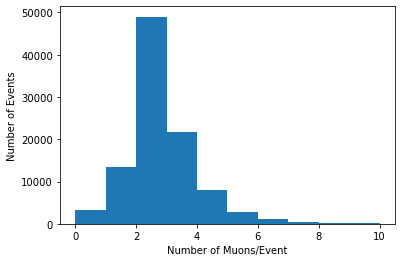

In [13]:
plt.hist(branches['nMuon'],bins=10,range=(0,10))
plt.xlabel('Number of Muons/Event')
plt.ylabel('Number of Events')
plt.show()

In [14]:
print(np.mean(branches['nMuon']))
print(np.std(branches['nMuon']))
print(np.max(branches['nMuon']))
print(np.min(branches['nMuon']))

2.35286
1.19175912851549
39
0


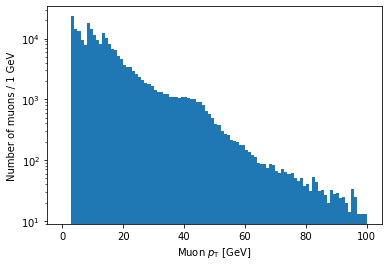

In [15]:
plt.hist(ak.flatten(branches['Muon_pt']),bins=100,range=(0,100))
plt.xlabel('Muon $p_{\mathrm{T}}$ [GeV]')
plt.ylabel('Number of muons / 1 GeV')
plt.yscale('log')
plt.show()

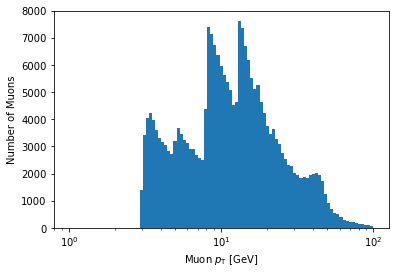

In [16]:
plt.hist(ak.flatten(branches['Muon_pt']), bins=np.logspace(np.log10(1), np.log10(100), 100))
plt.xlabel('Muon $p_{\mathrm{T}}$ [GeV]')
plt.xscale('log')
plt.ylabel('Number of Muons')
plt.show()

In [17]:
print(len(branches))
print(len(branches['Muon_pt']))

100000
100000


In [18]:
branches['nMuon'] == 1 #Checks to see if each entry has 1 muon, etc.

<Array [False, False, True, ... False, False] type='100000 * bool'>

In [19]:
#A mask is an array of boolean values that satisfies a specific criteria

single_muon_mask = branches['nMuon'] == 1

In [20]:
#Counting how many single-muon events there are, for example
#0 is false, 1 is true, sum adds the true and false events together

np.sum(single_muon_mask)

13447

In [21]:
#We can use masks as indices to cut out events we do not want

branches['Muon_pt'][single_muon_mask]

<Array [[3.28], [3.84], ... [13.3], [9.48]] type='13447 * var * float32'>

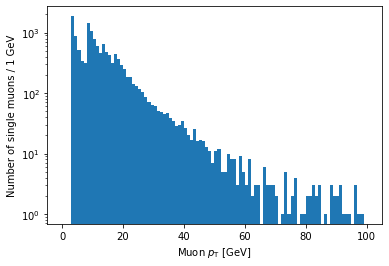

In [22]:
#Plotting the pT of only single-muon events

plt.hist(ak.flatten(branches['Muon_pt'][single_muon_mask]), bins=100, range=(0, 100))
plt.xlabel('Muon $p_{\mathrm{T}}$ [GeV]')
plt.ylabel('Number of single muons / 1 GeV')
plt.yscale('log')
plt.show()

In [23]:
eta_mask = abs(branches['Muon_eta']) < 2

print(eta_mask)

print(np.sum(eta_mask))

[[True, True], [True, True], [False], ... True], [True, True], [True, True, True]]
204564


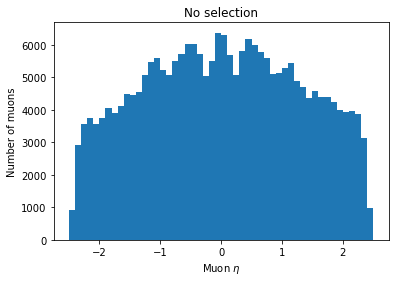

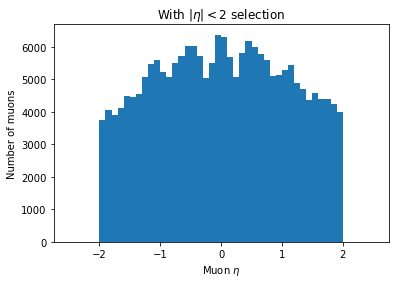

In [24]:
#Plotting original and afte-cut eta distributions

plt.hist(ak.flatten(branches['Muon_eta']), bins=50, range=(-2.5, 2.5))
plt.title('No selection')
plt.xlabel('Muon $\eta$')
plt.ylabel('Number of muons')
plt.show()

plt.hist(ak.flatten(branches['Muon_eta'][eta_mask]), bins=50, range=(-2.5, 2.5))
plt.title('With $|\eta| < 2$ selection')
plt.xlabel('Muon $\eta$')
plt.ylabel('Number of muons')
plt.show()

In [25]:
print(~single_muon_mask) #The ~ is the "not" operator so can invert selections

print(single_muon_mask & eta_mask) #Intersection between two selections

print(single_muon_mask | eta_mask) #The | is the "or" operator so union of selections

[True, True, False, True, True, True, True, ... True, True, True, True, True, True]
[[False, False], [False, False], [False, ... [False, False], [False, False, False]]
[[True, True], [True, True], [True], ... True], [True, True], [True, True, True]]


**Keep in mind that the operator "&" has a higher precedence than == so it is evaluated first.**

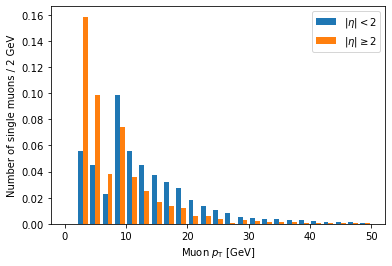

In [26]:
#Comparing distributions for different selections
#Add legends to differentiate
#Scale both distributions to see better so use density=True where density treats his as a PDF

plt.hist([ak.flatten(branches['Muon_pt'][single_muon_mask & eta_mask]), ak.flatten(branches['Muon_pt'][single_muon_mask & ~eta_mask])], label=['$|\eta| < 2$', '$|\eta| \geq 2$'],bins=25, density=True, range=(0, 50))
plt.xlabel('Muon $p_{\mathrm{T}}$ [GeV]')
plt.ylabel('Number of single muons / 2 GeV')
plt.legend()
plt.show()

In [27]:
#Row-based analysis
#For loops over every event and every muon in the event

eta_count = 0

for event in branches['Muon_eta']:
    for eta in event:
        if abs(eta) < 2:
            eta_count += 1
            
eta_count

204564

In [28]:
#Columnar analysis
#Running on all muons at once
#In this case, columnar approach is ~1000 faster

np.sum(abs(branches['Muon_eta']) < 2)

204564

**Finding dimuon invariant mass resonances**

In [29]:
two_muons_mask = branches['nMuon'] == 2

In [30]:
#Using vector package to get four-momenta of all muons and passing given arrays

muon_p4 = vector.zip({'pt':branches['Muon_pt'],'eta':branches['Muon_eta'],'phi':branches['Muon_phi'],'mass':branches['Muon_mass']})

ImportError: awkward 1.0.2 is too old; please upgrade to 1.2.0 or later

In [ ]:
#Masking events that do not contain two muons

two_muons_p4 = muon_p4[two_muons_mask]

print(two_muons_p4)

In [ ]:
two_muons_p4.pt
two_muons_p4.eta
two_muons_p4.phi
two_muons_p4.E
two_muons_p4.mass

In [ ]:
#To find the invariant mass of two muons/event, we need the sum of their 4-vectors

first_muon_p4 = two_muons_p4[:,0] #First muon/event using 2D slicing
second_muon_p4 = two_muons_p4[:, 1] #Second muon/event using 2D slicing

In [ ]:
plt.hist(first_muon_p4.deltaR(second_muon_p4), bins=100)
plt.xlabel('$\Delta R$ between muons')
plt.ylabel('Number of two-muon events')
plt.show()

#deltaR = sqrt(deltaEta^2 + deltaPhi^2)

In [ ]:
sum_p4 = first_muon_p4 + second_muon_p4
print(sum_p4) #1D array

In [ ]:
#Selecting pairs with opposite charges

two_muons_charges = branches['Muon_charge'][two_muons_mask]
opposite_sign_muons_mask = two_muons_charges[:, 0] != two_muons_charges[:, 1]

#Applying this to 4-vector sum to get dimuon 4-vectors

dimuon_p4 = sum_p4[opposite_sign_muons_mask]

In [ ]:
#Plot dimuon invariant mass to see resonances

plt.hist(dimuon_p4.mass, bins=np.logspace(np.log10(0.1), np.log10(1000), 200))
plt.xlabel('Dimuon invariant mass [GeV]')
plt.ylabel('Number of dimuon events')
plt.xscale('log')
plt.yscale('log')
plt.show()

**Fitting a distribution to the peak**

In [ ]:
plt.hist(dimuon_p4.mass, bins=40, range=(70, 110))
plt.xlabel('Dimuon invariant mass [GeV]')
plt.ylabel('Number of dimuon events / 1 MeV')
plt.show()

In [ ]:
#Fitting the relativistic Breit-Wigner distribution for resonances

def relativistic_breit_wigner(x, resonance_mass, width, normalization):
    gamma = np.sqrt(resonance_mass ** 2 * (resonance_mass ** 2 + width ** 2))
    k = 2.0 * np.sqrt(2) * resonance_mass * width * gamma / (np.pi * np.sqrt(resonance_mass ** 2 + gamma))
    return normalization * k / ((x ** 2 - resonance_mass ** 2) ** 2 + resonance_mass ** 2 * width ** 2)

bin_contents, bin_edges = np.histogram(dimuon_p4.mass.to_numpy(), bins=20, range=(80, 100))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0
popt, pcov = curve_fit(relativistic_breit_wigner, bin_centers, bin_contents, p0=[90, 10, 1000], sigma=np.sqrt(bin_contents))

plt.hist(dimuon_p4.mass, bins=40, range=(70, 110), label='Data')
x = np.linspace(80, 100, 200)
y = relativistic_breit_wigner(x, *popt)
plt.plot(x, y, label='Fit')
plt.xlabel('Dimuon invariant mass [GeV]')
plt.ylabel('Number of dimuon events / 1 MeV')
plt.legend()
plt.show()

In [ ]:
#The peak position is in popt[0]

popt[0]